In [ ]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

from lightning.pytorch import Trainer

from eotorch.data import (
    SegmentationDataModule,
    SemanticSegmentationTask,
    get_segmentation_dataset,
)
from eotorch.plot import plot_samples
from eotorch.processing import normalize

class_mapping = {
    1: "Baresoil",
    2: "Buildings",
    3: "Coniferous Trees",
    4: "Deciduous Trees",
    5: "Grass",
    6: "Impervious",
    7: "Water",
}

DATASET_DIR = Path("/teamspace/studios/training-data")
IMG_DIR = DATASET_DIR / "sr_data"
LABEL_DIR = DATASET_DIR / "labels"

NORM_DIR = Path.home() / "normalized"
NORM_DIR.mkdir(exist_ok=True)

assert IMG_DIR.is_dir()
assert LABEL_DIR.is_dir()

### Normalization and other preprocessing

In [ ]:
for f in IMG_DIR.rglob("*.tif"):
    print(f)
    out_file = NORM_DIR / f.parent.name / f.name
    out_file.parent.mkdir(exist_ok=True, parents=True)
    out_path = normalize(
        img_path=f, limits=(0.1, 99.5), out_path=out_file, sample_size=0.2
    )

### Create a segmentation dataset and visualize some samples

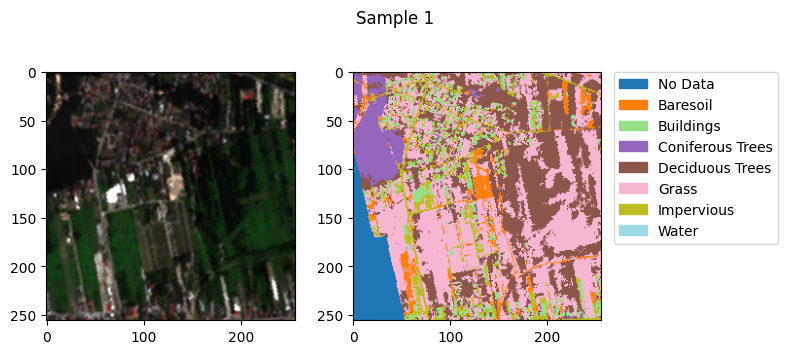

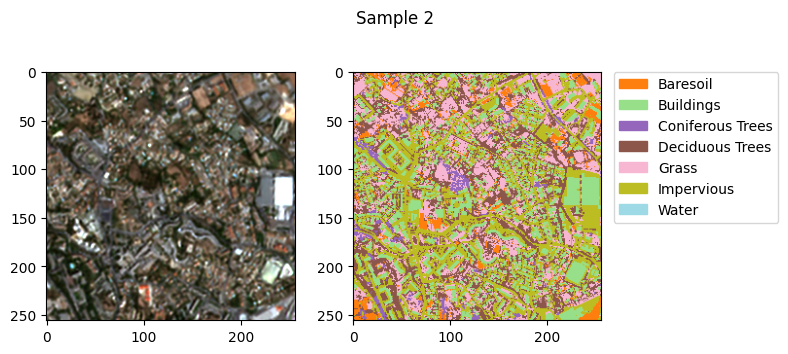

In [12]:
ds = get_segmentation_dataset(
    images_dir=NORM_DIR,
    labels_dir=LABEL_DIR,
    all_image_bands=("B02", "B03", "B04", "B08", "B11", "B12"),
    rgb_bands=("B04", "B03", "B02"),
    class_mapping=class_mapping,
    reduce_zero_label=True,
    cache_size=100,
)
plot_samples(ds, n=2, patch_size=256)


### Create a data module for training (everything related to data loading / splitting)

In [15]:
module = SegmentationDataModule(
    dataset=ds,
    batch_size=16,
    patch_size=256,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True,
)

### Create a task (PyTorch Lightning Module) for segmentation

In [ ]:
task = SemanticSegmentationTask(
    model="deepresunet",
    in_channels=6,
    num_classes=len(class_mapping),
    # loss="focal",
    ignore_index=-1,  # because reduce_zero_label=True
    # lr=1e-6,
)

### Create a PyTorch Lightning Trainer

This class allows you to modify many aspects of the model training

In [ ]:
trainer = Trainer()

### Fit the trainer

This will run the actual training of the model

In [ ]:
trainer.fit(model=task, datamodule=module)

### Use your model to make predictions

Specify the weights to use and an input tif file

Initializing model deepresunet with kwargs {'num_classes': 7, 'in_channels': 6, 'num_filters': 128}
Inference finished. |██████████████████████████████████████▉⚠︎| (!) 34/35 [97%] i
Showing results for /teamspace/studios/this_studio/predictions/20230419_pred.tif


PosixPath('/teamspace/studios/this_studio/predictions/20230419_pred.tif')

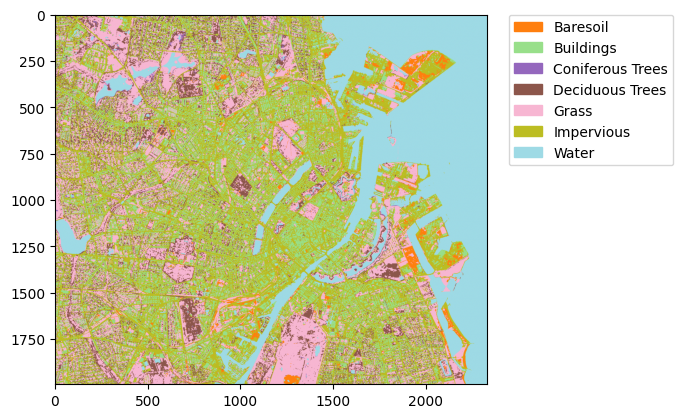

In [2]:
f = "/teamspace/studios/this_studio/eotorch/notebooks/lightning_logs/version_6/checkpoints/epoch=10-step=12672.ckpt"

SemanticSegmentationTask.predict_on_tif_file(
    tif_file_path="/teamspace/studios/this_studio/normalized/33UUB/20230419.tif",
    weights_path=f,
    patch_size=256,
    class_mapping=class_mapping,
    show_results=True,
    out_file_path="/teamspace/studios/this_studio/predictions/20230419_pred.tif",
)